<h1>Practice With Time Series Data Analysis</h1>
This is a synthetic data set given to me by a potential employer to analyse.

Since I put some decent work into it I'm sharing it for the group.

In [1]:
%%bash
date

Sun Mar 20 11:05:28 PDT 2016


In [2]:
#%install_ext https://raw.githubusercontent.com/rasbt/watermark/master/watermark.py
%load_ext watermark
%watermark -p numpy,scipy,pandas,matplotlib


numpy 1.10.1
scipy 0.16.0
pandas 0.16.2
matplotlib 1.4.0


#First Look

##Shell 

In [3]:
%%bash
root="/home/daniel/OrbitalInsights"
cat $root/data.csv | wc -l

1827


1826 rows of data

In [4]:
%%bash
root="/home/daniel/OrbitalInsights"
head -n 2 $root/data.csv
tail -n 1 $root/data.csv

date,day.of.week,car.count,weather
2010-01-01,friday,94.5,-0.1
2014-12-31,wednesday,166,-0.2


Data set for 5 years, Jan 1, 2010 to Dec 31 2014

In [5]:
1826 / 5.0 # guess sample rate

365.2

Probably 365 data points per year, one data point per day.

## Python

### Initial Plot

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
import scipy.signal as signal

In [102]:
df = pd.read_csv("/home/daniel/OrbitalInsights/data.csv")

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1826 entries, 0 to 1825
Data columns (total 4 columns):
date           1826 non-null object
day.of.week    1826 non-null object
car.count      1799 non-null float64
weather        1826 non-null float64
dtypes: float64(2), object(2)
memory usage: 71.3+ KB


In [104]:
df.head()

,date,day.of.week,car.count,weather
0,2010-01-01,friday,94.5,-0.1
1,2010-01-02,saturday,108.4,-2.4
2,2010-01-03,sunday,105.5,-0.5
3,2010-01-04,monday,109.6,-2.1
4,2010-01-05,tuesday,116.1,1.9


In [105]:
# like using Pandas b/c of the datetime features, resample or groupby
# but I haven't used date methods in a while and lost some time to redresh my memory
df['date'] = pd.to_datetime(df['date'])
df.set_index(df['date'], inplace=True)

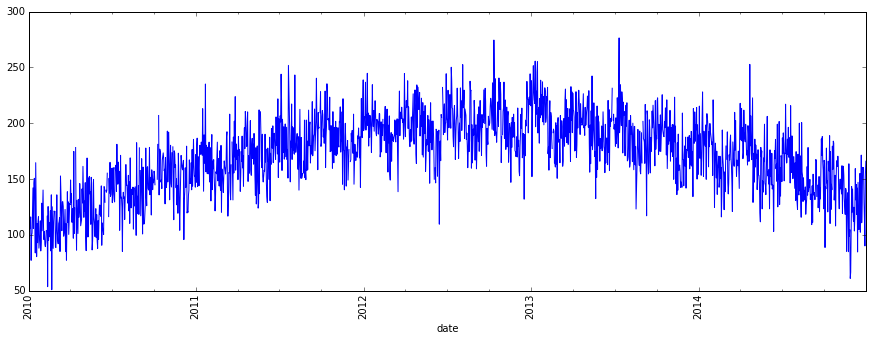

In [106]:
df['car.count'].plot(rot=90, figsize=(15,5));

I'd guess that we have a linear combination of a quadratic, sinusoid and random stochastic signal.


### Single Year Analysis: first year on record

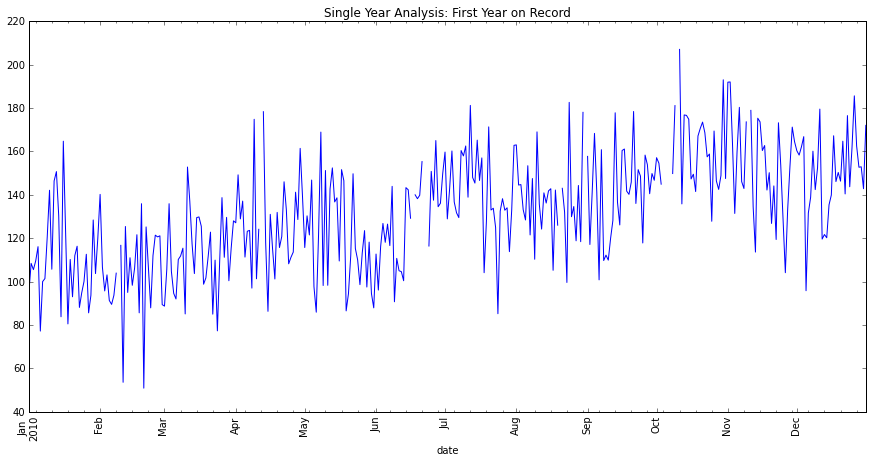

In [131]:
# year = df['car.count'][0:365]  if you are in a rush
year = df[df['date'] < pd.to_datetime('20110101')]['car.count']
year.plot(rot=90, figsize=(15,7), title="Single Year Analysis: First Year on Record");

In [108]:
#TODO: add to signal processing module

def remove_nans(data, return_nan_index=False):
    nan_ind = np.nonzero(~np.isfinite(data))[0]
    good_data_ind = np.nonzero(np.isfinite(data))[0]
    good_data = data[good_data_ind]
          
    new_points = np.interp(nan_ind, good_data_ind, good_data)
    data[nan_ind] = new_points
    
    if return_nan_index:
        return data, nan_ind
    else:
        return data

In [109]:
year, nan_ind = remove_nans(year.copy(), return_nan_index=True)
year_linear_det = signal.detrend(year, axis=0, type='linear')

Single Year Linear Detrend Time Series

(0, 366)

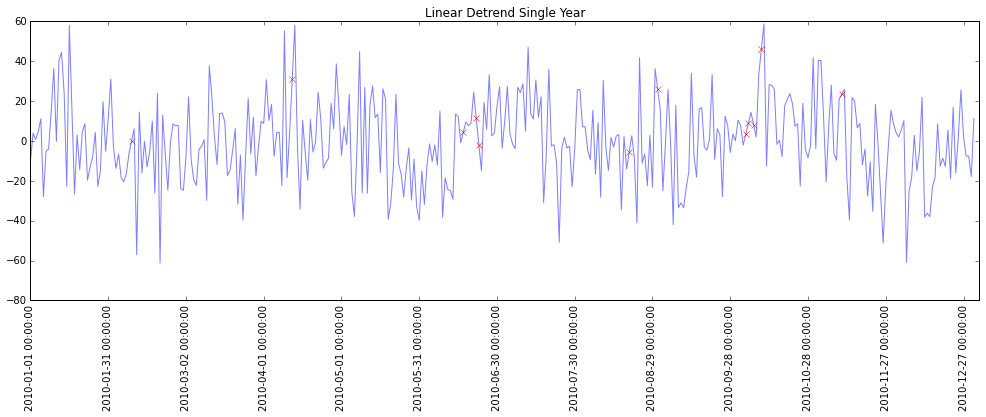

In [129]:
plt.figure(figsize=(17, 5))
plt.xticks(np.arange(year.shape[0])[0::30], year.index[0::30], rotation=90)
plt.plot(year_linear_det, alpha=0.5)
plt.title("Linear Detrend Single Year")
plt.plot(nan_ind, year_linear_det[nan_ind], 'rx')
plt.xlim(0, 366)

We see a $\approx$ 90 day period here.

Without more insight about the data we don't know if this is a nuisance or
a feature we are looking for.

The NaN replacements look reasonable.

## Group By for Sanity Check and Basic Analysis

<b>Group by Month: Global monthly trend averaging over the 5 samples of each month</b>

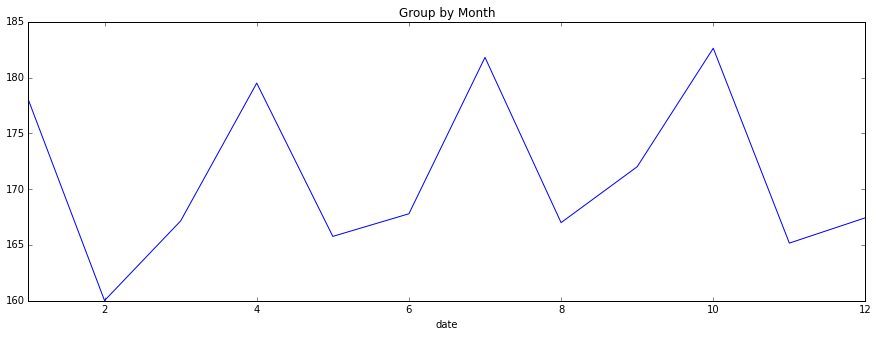

In [132]:
grp = df.groupby(df.date.map(lambda x:x.month))
grp.mean()['car.count'].plot(figsize=(15,5), title="Group by Month");

A group-by is sort of like a Fourier Transform where we choose just one frequency bin. There's the sinusodial period $\approx$ 90 days.

<b>Group by Day: Global day trend averaging over the 5 samples of each day<b>

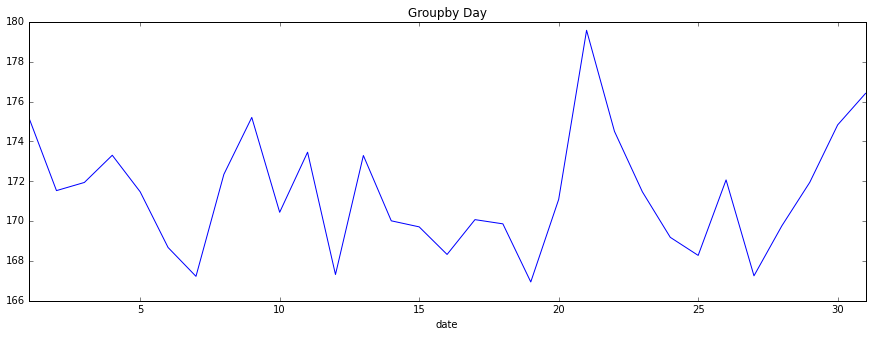

In [133]:
grp = df.groupby(df.date.map(lambda x:x.day))
grp.mean()['car.count'].plot(figsize=(15,5), title="Groupby Day");

It would appear as though the 21st day of each month saw greater count. 

## FFT
I keep this method handy, I didn't re-write just cut and paste rather than import so that you can see what's inside.

In [134]:
def fft(data):
        '''Plot FFT using Welch's method, daily resolution '''
        f, y = signal.welch(data, fs=1.0, nperseg=365, noverlap=None, nfft=512, scaling='spectrum', detrend="linear")
        
        interval = 3 # days
        periods = np.round(1/f[0::interval], 1)
        # clean up frequency of 0 Hz
        periods[0] = 0
        
        frqs = f[0::interval]
        plt.xticks(frqs, periods, rotation="vertical")
        
        plt.plot(f, y)
        
        plt.grid(True) # not working likely b/c of conflict with seaborn artist
        plt.title("Welch FFT: Counts")
        plt.ylabel("Relative ratio of spectrum")
        plt.xlabel("Number of days in a period")
               
        return f, y, frqs

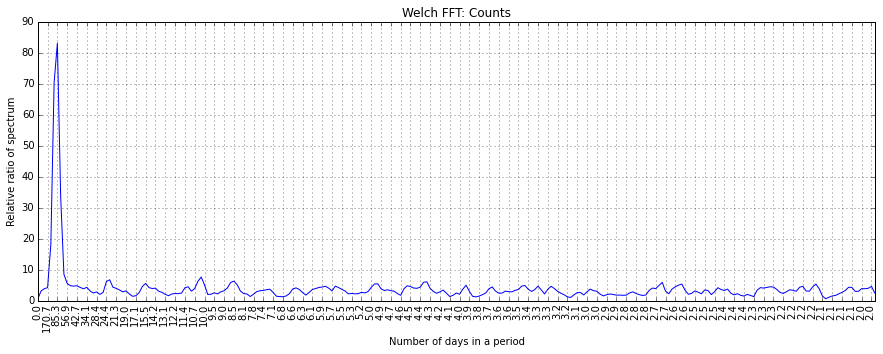

In [136]:
plt.figure(figsize=(15,5))
counts = remove_nans(df['car.count'].copy())
f, y, frqs = fft(counts)

## Quadratic Detrend Via PolyFit

In [137]:
poly =  np.polynomial.polynomial             

In [142]:
t = np.arange(df.shape[0])
coefs, stats = poly.polyfit(t, df['car.count'], deg=2, full=True)

In [143]:
fit_curve = poly.polyval(t, coefs)

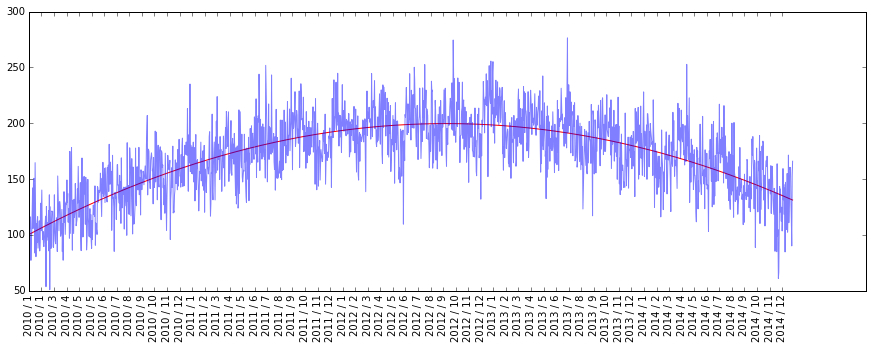

In [144]:
plt.figure(figsize=(15,5))
plt.plot(fit_curve, 'r')
plt.plot(t, df['car.count'], alpha=0.5)
labels = df['date']
date_str = map(lambda x: str(x.year) + " / "  + str(x.month), labels)
plt.xticks(t[0::30], date_str[0::30], rotation="vertical");

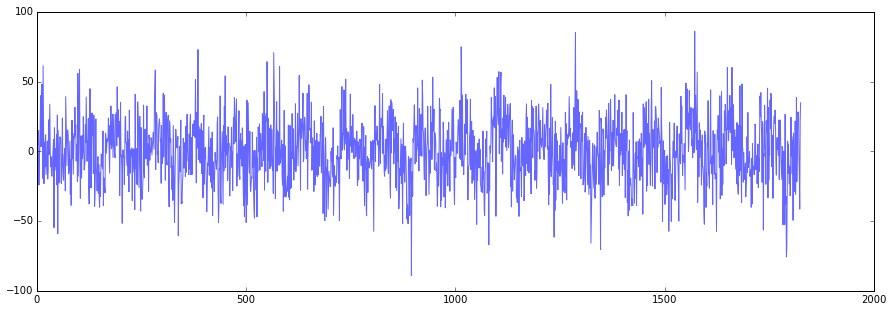

In [146]:
det_curve = df['car.count'] - fit_curve
plt.figure(figsize=(15,5))
plt.plot(det_curve, alpha=0.6);

## Further Confound Removal
Lets suppose that the quadratic is a measurement error and that the $\approx$ 90 day sinusodial is a well understood or nuisance, then we'll examine the remainder of the signal.

In [147]:
import sys
sys.path.append("/home/daniel/git/Python/MRI/Modules")
import SignalProcessTools

In [148]:
sigtools = SignalProcessTools.SignalProcessTools()

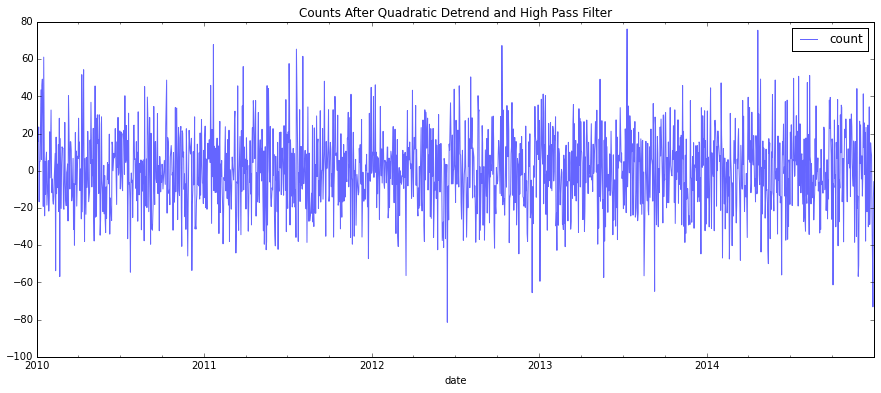

In [157]:
frq = 1.0 / 85.3 # from FFT output above
out = sigtools.hi_pass_filter(det_curve, frq, 1.0, 2)
dff = pd.DataFrame({'count':out}, index=df.index)
dff.plot(title="Counts After Quadratic Detrend and High Pass Filter", figsize=(15,6), alpha=0.6)

In [ ]:
nbins = np.floor(np.sqrt(out.shape[0]))
plt.figure(figsize=(15,8))
y_counts, bin_x, patch = plt.hist(out, nbins, normed=True, alpha=0.5);
string = "Histrogram With %s Bins" % str(int(nbins))
plt.title(string)

Perhaps a Gausian.
<html></html>

In [ ]:
bin_x = bin_x[1:]# drop the first bin to match the array lengths

In [ ]:
from scipy.optimize import curve_fit

In [ ]:
def gauss(x, *p):
    A, mu, sig = p
    gau = A * np.exp(-(x-mu)**2 / 2.0 * sig**2)
    return gau

In [ ]:
coeff, var_matrix = curve_fit(gauss, bin_x, y_counts, p0=[0.1, 0.0, 0.1])
print coeff

In [ ]:
plt.figure(figsize=(12,12))
fit_gau = gauss(bin_x, *coeff)
plt.plot(bin_x, fit_gau, 'r')
plt.bar(bin_x, y_counts, alpha=0.4, width=3)

# Summary Write Up

Longer time scale:
If we were asked about global count increase, we could use the yearly and fit a quadratic to see that global 
trend.

Shorter time scale:
There's probably a strong correlation with some external related time series data that characterizes typical driving use cases.

Clearly there's an 85 day period with freqency $f = 1/T$ giving $f \approx$ 3 month recurring feature of high counts.